In [1]:
%matplotlib inline
import matplotlib
import collections as col
import numpy as np
import matplotlib.pylab as plt
import ghostpy.Invariants.LShell as ls
import ghostpy.algorithms.convert as algx
import ghostpy.algorithms.common as algc
import ghostpy.algorithms.FieldTracers as ft
import ghostpy.algorithms.DipoleField as df
import ghostpy.data.VtkData as vdt
import ghostpy.data.LfmVtkData as lvdt
import ghostpy.data.DipoleData as dpd
import ghostpy.data.GpData as gpd
import ghostpy.plotting.FieldLinePlot as flplt
import ghostpy.Invariants.FieldLine as fl
from matplotlib.ticker import FormatStrFormatter

import csv

In [2]:
data_dpg3 = vdt.VtkData(filename="../unit_tests/test_data/lfm_dipole_test_single.vts", vector="B")
data_dpg7 = vdt.VtkData(filename="../unit_tests/test_data/lfm_dipole_test_double.vts", vector="B")
data_dpg9 = vdt.VtkData(filename="../unit_tests/test_data/lfm_dipole_test_quad.vts", vector="B")
print ("Data Sources Configured.")

Data Sources Configured.


In [3]:
error_dataS = dict()

loc_list = col.OrderedDict()

In [4]:
tcount = 150

relist = np.linspace(start=3.0, stop=8.0, num=5000, endpoint=True)

relist = np.random.choice(relist, size=150, replace=False)

lamlist = np.linspace(start=-np.pi/4, stop=np.pi/4, num=5000, endpoint=True)
lamlist = np.random.choice(lamlist, size=150, replace=False)

phi_list = np.linspace(start=0, stop=np.pi*2, num=16, endpoint=False)
# phi_list = np.random.choice(phi_list, size=16, replace=True)

for phi in phi_list:
    x,y,z = algc.sphere_to_cart(r=relist, lam=lamlist, phi=phi)
    loc_list[phi] = np.column_stack((x,y,z))
    
    
    
print (phi_list)

[ 0.          0.39269908  0.78539816  1.17809725  1.57079633  1.96349541
  2.35619449  2.74889357  3.14159265  3.53429174  3.92699082  4.3196899
  4.71238898  5.10508806  5.49778714  5.89048623]


In [5]:
re = 3.0

In [6]:
# for phi in loc_list:
#     fp_ideal = []
#     Ls = []
#     for loc in loc_list[phi]:
#         Ls.append(algc.mag(loc))
#         fp_ideal.append(df.dipole_footprint(L=L, r=re))
# 
#     fp_ideal = np.array(fp_ideal)
#     Ls = np.array(Ls)
#     ideal_data[phi] = [Ls, fp_ideal]

In [7]:
LS = col.OrderedDict()
error_dataS = col.OrderedDict()
eerat_S = col.OrderedDict()
eLS = col.OrderedDict()
LCS = col.OrderedDict()

for phi in loc_list:
    fpe = []
    fp_L = []
    lc = []
    Lerr = []
    for loc in loc_list[phi]:
        fl3 = fl.FieldLine(data=data_dpg3, start=loc, error_tol=1e-6, smooth=19)
        fpn = fl3.get_footprint_rlp(re=re)
        if not np.any(np.isnan(fpn)):
            pos = algc.cart_to_sphere(loc)
            lam = pos[1]
            L = df.dipole_L_rad(lam=lam, r=pos[0])
    
            fp_L.append(L)
            fp_i = df.dipole_footprint(L=L, r=fpn[0])
            Elam = np.abs(fp_i - fpn[1])
            fpe.append(Elam)
                        
            Li = df.dipole_L_rad(lam=fp_i, r=fpn[0])
            Lc = df.dipole_L_rad(lam=fpn[1], r=fpn[0])
            lc.append(Lc)

            El = Li - Lc
            eer = np.float(El/Elam)
            Lerr.append(El)


            try:
                eerat_S[L].append(eer)
            except KeyError:
                eerat_S[L] = []
                eerat_S[L].append(eer)
            except ValueError as vr:
                print ("VALUE ERROR: {}".format(vr))
                print ("eer: {}".format([eer]))
                print ("eerat_S[lam]: {}".format(eerat_S[lam]))
                assert False
    
    error_dataS[phi] = np.array(fpe)
    LS[phi] = np.array(fp_L)
    LCS[phi] = np.array(lc)
    eLS[phi] = np.array(Lerr)

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/Users/jjm390/src/ghostpy/ghostpy/ghostpy/Invariants/FieldLine.py:795: RuntimeWarning: invalid value encountered in sqrt
  k = np.sqrt(int_list[0] - int_list) * dtrace
/Users/jjm390/src/ghostpy/ghostpy/ghostpy/Invariants/FieldLine.py:689: RuntimeWarning: All-NaN slice encountered
  n_k = np.nanmax([kf,kb], axis=0)


In [8]:
LD = col.OrderedDict()
error_dataD = col.OrderedDict()
eerat_D = col.OrderedDict()
eLD = col.OrderedDict()
LCD = col.OrderedDict()

for phi in loc_list:
    fpe = []
    Lerr = []
    fp_L = []
    lc = []
    for loc in loc_list[phi]:
        fl3 = fl.FieldLine(data=data_dpg7, start=loc, error_tol=1e-6, smooth=19)
        fpn = fl3.get_footprint_rlp(re=re)
        if not np.any(np.isnan(fpn)):
            pos = algc.cart_to_sphere(loc)
            L = df.dipole_L_rad(lam=pos[1], r=pos[0])
            fp_L.append(L)
            fp_i = df.dipole_footprint(L=L, r=fpn[0])
            Elam = np.abs(fp_i - fpn[1])
            fpe.append(np.abs(Elam))
            
            Li = df.dipole_L_rad(lam=fp_i, r=fpn[0])
            Lc = df.dipole_L_rad(lam=fpn[1], r=fpn[0])
            lc.append(Lc)
            
            El = Li - Lc
            eer = np.float(El/Elam)
            
            Lerr.append(El)

            try:
                eerat_D[L].append(eer)
            except KeyError:
                eerat_D[L] = []
                eerat_D[L].append(eer)
            except ValueError as vr:
                print ("VALUE ERROR: {}".format(vr))
                print ("eer: {}".format([eer]))
                print ("eerat_S[lam]: {}".format(eerat_D[lam]))
                assert False   
    
    error_dataD[phi] = np.array(fpe)
    LD[phi] = np.array(fp_L)
    LCD[phi] = np.array(lc)
    eLD[phi] = np.array(Lerr)

In [9]:
LQ = col.OrderedDict()
error_dataQ = col.OrderedDict()
eerat_Q = col.OrderedDict()
eLQ = col.OrderedDict()
LCQ = col.OrderedDict()

for phi in loc_list:
    fpe = []
    fp_L = []
    lc = []
    Lerr = []
    for loc in loc_list[phi]:
        fl3 = fl.FieldLine(data=data_dpg9, start=loc, error_tol=1e-6, smooth=19)
        fpn = fl3.get_footprint_rlp(re=re)
        if not np.any(np.isnan(fpn)):
            pos = algc.cart_to_sphere(loc)
            L = df.dipole_L_rad(lam=pos[1], r=pos[0])
            fp_L.append(L)
            fp_i = df.dipole_footprint(L=L, r=fpn[0])
            Elam = np.abs(fp_i - fpn[1])
            fpe.append(np.abs(Elam))
            
            Li = df.dipole_L_rad(lam=fp_i, r=fpn[0])
            Lc = df.dipole_L_rad(lam=fpn[1], r=fpn[0])
            lc.append(Lc)
            
            El = Li - Lc
            eer = np.float(El/Elam)
            Lerr.append(El)

            try:
                eerat_Q[L].append(eer)
            except KeyError:
                eerat_Q[L] = []
                eerat_Q[L].append(eer)
            except ValueError as vr:
                print ("VALUE ERROR: {}".format(vr))
                print ("eer: {}".format([eer]))
                print ("eerat_S[lam]: {}".format(eerat_Q[lam]))
                assert False               
    
    error_dataQ[phi] = np.array(fpe)
    LQ[phi] = np.array(fp_L)
    LCQ[phi] = np.array(lc)
    eLQ[phi] = np.array(Lerr)

In [10]:
import pickle





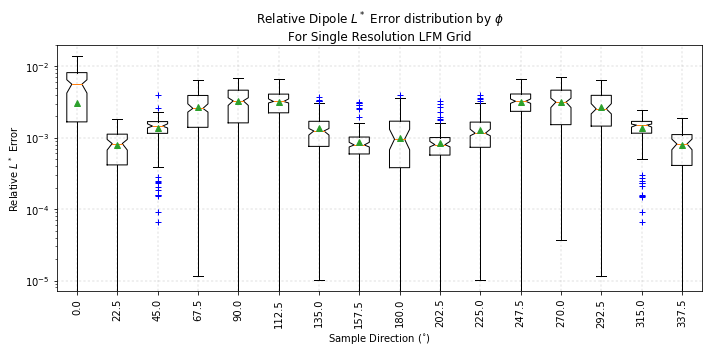

In [11]:
# Generate Box Plots
from matplotlib.ticker import FormatStrFormatter

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

# ax.set_yticklabels([])
keys = sorted(error_dataS.keys())


dataS = eLS[keys[0]]

for key in keys[1:]:
    dataS = np.column_stack([dataS, eLS[key]/LS[key]])
 
    
        
degs = algx.rad_to_deg(np.array(keys))
ax.set_yscale('log')

ax.boxplot(dataS, 1, labels=degs, showmeans=True, meanline=False, bootstrap=10000, sym='b+')

ax.set_title("Relative Dipole $L^*$ Error distribution by $\phi$\nFor Single Resolution LFM Grid")
ax.set_ylabel("Relative $L^*$ Error")
ax.set_xlabel("Sample Direction ($^{\circ}$)")

plt.xticks(rotation=90)
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.tight_layout()
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_single.pdf")

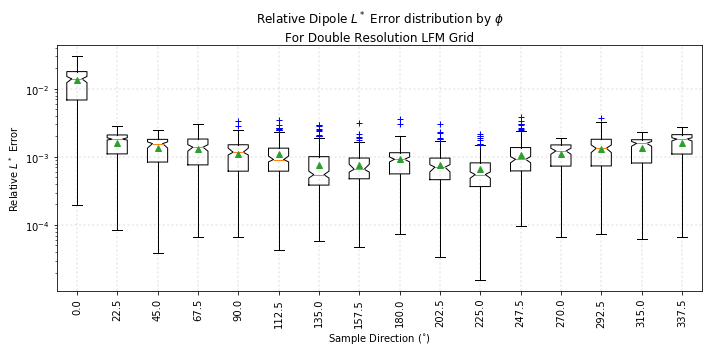

In [12]:
# Generate Box Plots
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
# ax.set_yticklabels([])
keys = sorted(error_dataD.keys())


dataD = eLD[keys[0]]

for key in keys[1:]:
    dataD = np.column_stack([dataD, eLD[key]/LD[key]])
       
degs = algx.rad_to_deg(np.array(keys))
ax.set_yscale('log')

ax.boxplot(dataD, 1, labels=degs, showmeans=True, meanline=False, bootstrap=10000, sym='b+')
ax.set_title("Relative Dipole $L^*$ Error distribution by $\phi$\nFor Double Resolution LFM Grid")
ax.set_ylabel("Relative $L^*$ Error")
ax.set_xlabel("Sample Direction ($^{\circ}$)")
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.xticks(rotation=90)
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.tight_layout()
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_double.pdf")

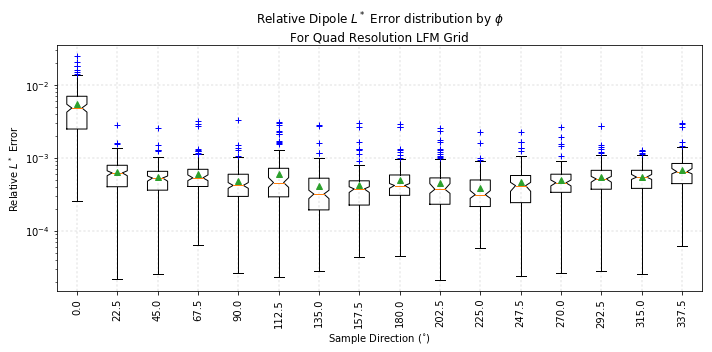

In [13]:
# Generate Box Plots
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
# ax.set_yticklabels([])
keys = sorted(error_dataQ.keys())


dataQ = eLQ[keys[0]]

for key in keys[1:]:
    dataQ = np.column_stack([dataQ, eLQ[key]/LQ[key]])
       
degs = algx.rad_to_deg(np.array(keys))
ax.set_yscale('log')

ax.boxplot(dataQ, 1, labels=degs, showmeans=True, meanline=False, bootstrap=10000, sym='b+')
ax.set_title("Relative Dipole $L^*$ Error distribution by $\phi$\nFor Quad Resolution LFM Grid")
ax.set_ylabel("Relative $L^*$ Error")
ax.set_xlabel("Sample Direction ($^{\circ}$)")
# ax.xaxis.set_major_formatter(FormatStrFormatter('%6.2f'))

plt.xticks(rotation=90)
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.tight_layout()
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_quad.pdf")

In [14]:
# fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111)
# 
# ax.semilogy(np.arange(len(dataS.T[0])), dataS.T[9], 'k', lw=1, label="LFM Single")
# ax.semilogy(np.arange(len(dataD.T[0])), dataD.T[9], 'r', lw=1, label="LFM Double")
# ax.semilogy(np.arange(len(dataQ.T[0])), dataQ.T[9], 'b', lw=1, label="LFM Quad")
# 
# # ax.semilogy(x, fpe7, 'b', lw=1,label="LFM Double")
# # ax.semilogy(x, fpe9, 'r', lw=1,label="LFM Quad")
# # ax.semilogy(x, (np.abs(fp17 - fp_ideal)), 'y', lw=1,label="1/17 RE Grid")
# # ax.plot(x, (algx.rad_to_deg(np.abs(fp19 - fp_ideal))), label="1/19 RE Rect. Grid")
# 
# ax.set_ylabel("Absolute $\lambda$ intersection Error")
# ax.set_xlabel("L")
# ax.set_title("$\lambda$ Error Comparisons - Dipole on LFM Grids\n$\phi={}$".format(degs[2]))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# 
# plt.legend(loc='best')
# plt.tight_layout()
# plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
# plt.show()
# fig.tight_layout()
# fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_error.pdf")

2400


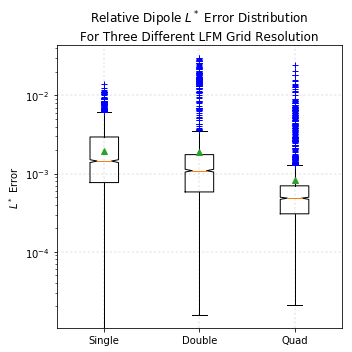

In [53]:
# Generate Box Plots
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# ax.set_yticklabels([])
keys = sorted(error_dataQ.keys())


dataQ2 = eLQ[keys[0]]

for key in keys[1:]:
    dataQ2 = np.column_stack([dataQ, eLQ[key]/LQ[key]])
    
dataD2 = eLD[keys[0]]

for key in keys[1:]:
    dataD2 = np.column_stack([dataD2, eLD[key]/LD[key]])
       
dataS2 = eLS[keys[0]]

for key in keys[1:]:
    dataS2 = np.column_stack([dataS2, eLS[key]/LS[key]])
       
dataS2 = dataS2.flatten()
dataD2 = dataD2.flatten()
dataQ2 = dataQ2.flatten()
       
minLength = np.min([len(dataS2), len(dataD2), len(dataQ2)])

print (minLength)
       
data = np.column_stack([dataS2[:minLength-1], dataD2[:minLength-1], dataQ2[:minLength-1]])
labels = ["Single", "Double", "Quad"]
       

degs = algx.rad_to_deg(np.array(keys))
ax.set_yscale('log')

ax.boxplot(data, 1, labels=labels, bootstrap=10000,  showmeans=True, meanline=False, sym='b+')
ax.set_title("Relative Dipole $L^*$ Error Distribution\nFor Three Different LFM Grid Resolution")
ax.set_ylabel("$L^*$ Error")
# ax.xaxis.set_major_formatter(FormatStrFormatter('%6.2f'))

# plt.xticks(rotation=90)
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.tight_layout()
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_full.pdf")

In [16]:
# # Generate Box Plots
# fig = plt.figure(figsize=(5,10))
# ax = fig.add_subplot(111)
# # ax.set_yticklabels([])
# keys = sorted(error_dataQ.keys())
# 
# 
# dataQ2 = error_dataQ[keys[0]]
# 
# for key in keys[1:]:
#     dataQ2 = np.column_stack([dataQ, error_dataQ[key]])
#        
# degs = algx.rad_to_deg(np.array(keys))
# ax.set_yscale('log')
# 
# ax.boxplot(dataQ2.flatten(), 1, labels=["Sample Space Error Distribution"], bootstrap=10000,  showmeans=True, meanline=False, sym='b+')
# ax.set_title("Dipole $\lambda$ Error Distribution\nFor Quad Resolution LFM Grid")
# ax.set_ylabel("Absolute $\lambda$ Error")
# # ax.xaxis.set_major_formatter(FormatStrFormatter('%6.2f'))
# 
# # plt.xticks(rotation=90)
# plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
# fig.tight_layout()
# fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_quad_full.pdf")

In [17]:
# # Generate Box Plots
# fig = plt.figure(figsize=(5,10))
# ax = fig.add_subplot(111)
# # ax.set_yticklabels([])
# keys = sorted(error_dataD.keys())
# 
# 
# dataD2 = error_dataD[keys[0]]
# 
# for key in keys[1:]:
#     dataD2 = np.column_stack([dataD2, error_dataD[key]])
#        
# degs = algx.rad_to_deg(np.array(keys))
# ax.set_yscale('log')
# 
# ax.boxplot(dataD2.flatten(), 1, labels=["Sample Space Error Distribution"], bootstrap=10000,  showmeans=True, meanline=False, sym='b+')
# ax.set_title("Dipole $\lambda$ Error Distribution\nFor Double Resolution LFM Grid")
# ax.set_ylabel("Absolute $\lambda$ Error")
# # ax.xaxis.set_major_formatter(FormatStrFormatter('%6.2f'))
# 
# # plt.xticks(rotation=90)
# plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
# fig.tight_layout()
# fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_double_full.pdf")

In [18]:
# # Generate Box Plots
# fig = plt.figure(figsize=(5,10))
# ax = fig.add_subplot(111)
# # ax.set_yticklabels([])
# keys = sorted(error_dataS.keys())
# 
# 
# dataS2 = error_dataS[keys[0]]
# 
# for key in keys[1:]:
#     dataS2 = np.column_stack([dataS2, error_dataS[key]])
#        
# degs = algx.rad_to_deg(np.array(keys))
# ax.set_yscale('log')
# 
# ax.boxplot(dataS2.flatten(), 1, labels=["Sample Space Error Distribution"], bootstrap=10000,  showmeans=True, meanline=False, sym='b+')
# ax.set_title("Dipole $\lambda$ Error Distribution\nFor Single Resolution LFM Grid")
# ax.set_ylabel("Absolute $\lambda$ Error")
# # ax.xaxis.set_major_formatter(FormatStrFormatter('%6.2f'))
# 
# # plt.xticks(rotation=90)
# plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
# fig.tight_layout()
# fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/LFM_grid_fp_BoxPlot_single_full.pdf")

In [19]:
# medD = np.median(dataD)
print (np.median(dataS))
print (np.std(dataS))
print (np.mean(dataS))

0.00145002448665
0.00266555142693
0.00192172939128


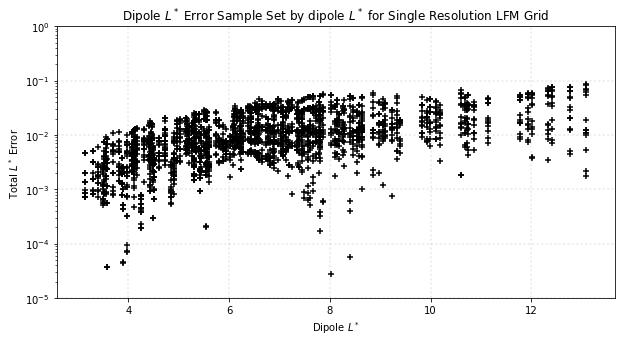

In [43]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')

for key in error_dataS:
    # leS[key] = np.column_stack([error_dataS[key], LS[key]])
    ax.scatter(LS[key], eLS[key], marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error Sample Set by dipole $L^*$ for Single Resolution LFM Grid")
ax.set_xlabel("Dipole $L^*$")
ax.set_ylabel("Total $L^*$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_single_L.pdf")

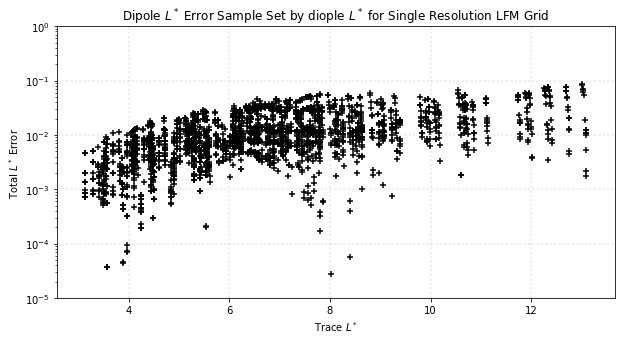

In [44]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')

for key in error_dataS:
    # leS[key] = np.column_stack([error_dataS[key], LS[key]])
    ax.scatter(LCS[key], eLS[key], marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error Sample Set by diople $L^*$ for Single Resolution LFM Grid")
ax.set_xlabel("Trace $L^*$")
ax.set_ylabel("Total $L^*$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_single_LC.pdf")

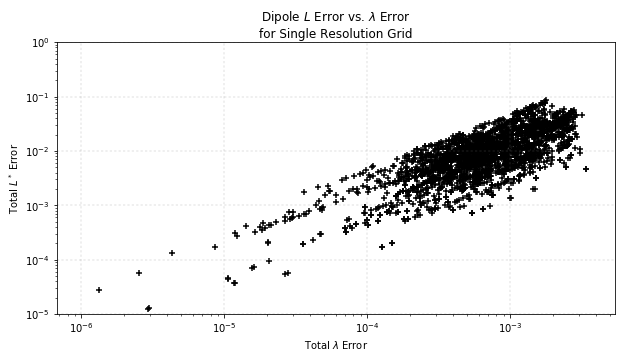

In [45]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')


for key in error_dataS:
    # leS[key] = np.column_stack([error_dataS[key], LS[key]])
    ax.scatter(error_dataS[key], np.abs(LS[key]-LCS[key]), marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L$ Error vs. $\lambda$ Error\nfor Single Resolution Grid")
ax.set_ylabel("Total $L^*$ Error")
ax.set_xlabel("Total $\lambda$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_single_LErr.pdf")

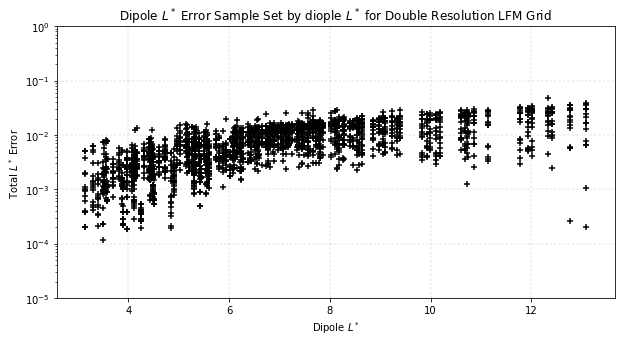

In [46]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')

for key in error_dataD:
    # leD[key] = np.column_stack([error_dataD[key], LD[key]])
    ax.scatter(LD[key], eLD[key], marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error Sample Set by diople $L^*$ for Double Resolution LFM Grid")
ax.set_xlabel("Dipole $L^*$")
ax.set_ylabel("Total $L^*$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_double_L.pdf")

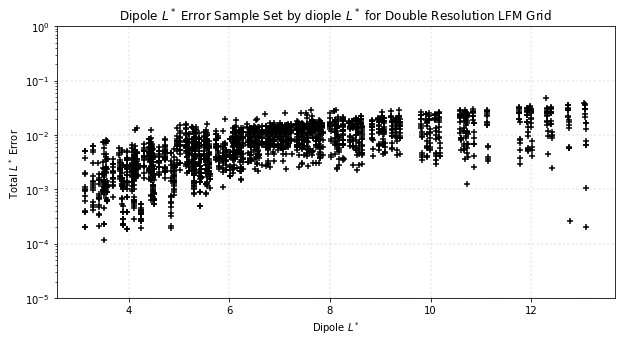

In [47]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')

for key in error_dataD:
    # leD[key] = np.column_stack([error_dataD[key], LD[key]])
    ax.scatter(LCD[key], eLD[key], marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error Sample Set by diople $L^*$ for Double Resolution LFM Grid")
ax.set_xlabel("Dipole $L^*$")
ax.set_ylabel("Total $L^*$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_double_LCD.pdf")

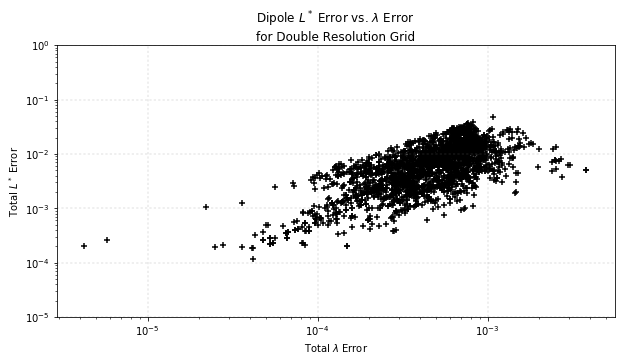

In [48]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')


for key in error_dataD:
    # leS[key] = np.column_stack([error_dataS[key], LS[key]])
    ax.scatter(error_dataD[key], np.abs(LD[key]-LCD[key]), marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error vs. $\lambda$ Error\nfor Double Resolution Grid")
ax.set_ylabel("Total $L^*$ Error")
ax.set_xlabel("Total $\lambda$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_double_LErr.pdf")

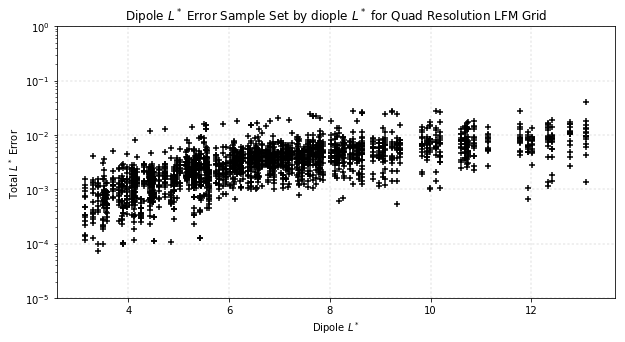

In [49]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')

for key in error_dataQ:
    # leD[key] = np.column_stack([error_dataD[key], LD[key]])
    ax.scatter(LQ[key], eLQ[key], marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error Sample Set by diople $L^*$ for Quad Resolution LFM Grid")
ax.set_xlabel("Dipole $L^*$")
ax.set_ylabel("Total $L^*$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_quad_L.pdf")

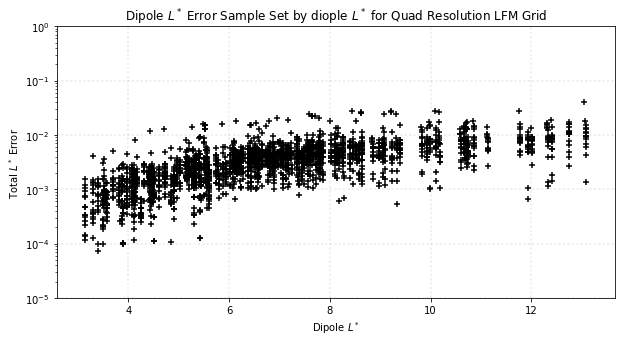

In [50]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')

for key in error_dataQ:
    # leD[key] = np.column_stack([error_dataD[key], LD[key]])
    ax.scatter(LCQ[key], eLQ[key], marker='+', color='k')
    
ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L^*$ Error Sample Set by diople $L^*$ for Quad Resolution LFM Grid")
ax.set_xlabel("Dipole $L^*$")
ax.set_ylabel("Total $L^*$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_quad_LCQ.pdf")

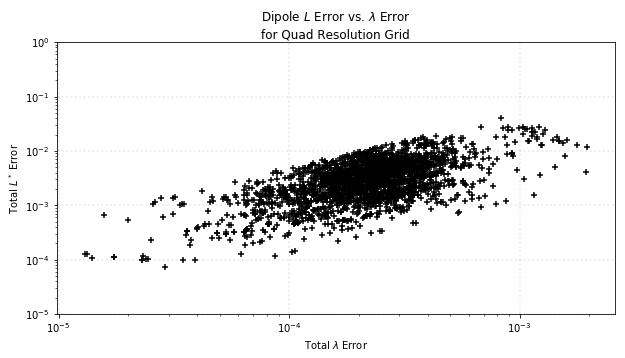

In [51]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.set_xscale('log')


for key in error_dataQ:
    # leS[key] = np.column_stack([error_dataS[key], LS[key]])
    ax.scatter(error_dataQ[key], np.abs(LQ[key]-LCQ[key]), marker='+', color='k')

ax.set_ylim([1e-5, 1e0])
ax.set_title("Dipole $L$ Error vs. $\lambda$ Error\nfor Quad Resolution Grid")
ax.set_ylabel("Total $L^*$ Error")
ax.set_xlabel("Total $\lambda$ Error")
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/lambda_samples_quad_LErr.pdf")

In [52]:
print (np.median(dataD))
print (np.std(dataD))
print (np.mean(dataD))

0.00109153098261
0.003581070999
0.00188679412496


In [30]:
print (np.median(dataQ))
print (np.std(dataQ))
print (np.mean(dataQ))

0.000478920394426
0.0016342363217
0.000829499538978


In [31]:
medS = np.median(dataS, axis=0)
print (medS)

[ 0.0055974   0.00082666  0.00145057  0.00256903  0.003275    0.00320865
  0.00124031  0.00079016  0.00095232  0.00079773  0.0011522   0.00323235
  0.00314679  0.00252321  0.00149756  0.0008162 ]


In [32]:
medQ = np.median(dataQ, axis=0)
print (dataQ)

[[ 0.00480983  0.00065141  0.00059946 ...,  0.00071285  0.00068686
   0.00063014]
 [ 0.00378805  0.00061244  0.00056254 ...,  0.00045863  0.00043516
   0.00065872]
 [ 0.01000978  0.00081634  0.00053537 ...,  0.00077208  0.00052099
   0.00068826]
 ..., 
 [ 0.00545319  0.00087043  0.00057529 ...,  0.00045698  0.00086447
   0.00069274]
 [ 0.01029165  0.00096061  0.00050021 ...,  0.00059817  0.00063888
   0.00087176]
 [ 0.01097706  0.00133611  0.00082098 ...,  0.00064633  0.00051256
   0.00128136]]


In [33]:
# print (sorted(eerat_S.keys()))

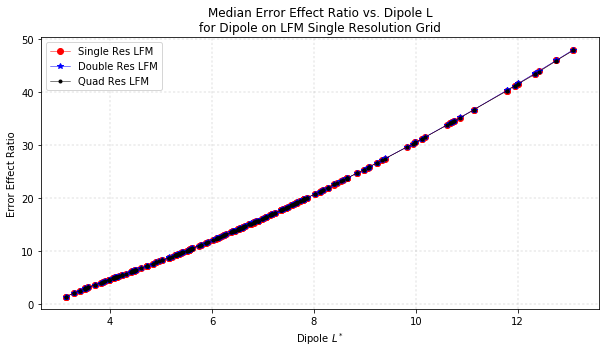

In [38]:
leS = {}
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
# ax.set_yscale('log')
keys = eLS.keys()
xyd = []
xyq = []
xys = []
for keyS in eerat_S:
    exS = keyS
    eyS = np.median(eerat_S[keyS])
    if eyS > np.finfo(np.float64).eps:
        xys.append([exS, eyS])
        
for keyD in eerat_D:
    exD = keyD
    eyD = np.median(eerat_D[keyD])
    if eyD > np.finfo(np.float64).eps:
        xyd.append([exD, eyD])
        
for keyQ in eerat_Q:
    exQ = keyQ
    eyQ = np.median(eerat_Q[keyQ])
    if eyQ > np.finfo(np.float64).eps:
        xyq.append([exQ, eyQ])

xys = np.array(xys)
xys = np.sort(xys, axis=0)

xyd = np.array(xyd)
xyd = np.sort(xyd, axis=0)

xyq = np.array(xyq)
xyq = np.sort(xyq, axis=0)

# ax.scatter(xy[:,0], xy[:,1], marker=".", color='k')
ax.plot(xyd[:,0], xyd[:,1], 'ro-', lw=0.5, label="Single Res LFM")
ax.plot(xyq[:,0], xyq[:,1], 'b*-', lw=0.5, label="Double Res LFM")
ax.plot(xys[:,0], xys[:,1], 'k.-', lw=0.5, label="Quad Res LFM")

ax.set_title("Median Error Effect Ratio vs. Dipole L\nfor Dipole on LFM Single Resolution Grid")
ax.set_xlabel("Dipole $L^*$")
ax.set_ylabel("Error Effect Ratio")
plt.legend()
plt.grid(b=True, which='major', color='grey', linewidth=0.25, linestyle=':')
fig.savefig("/Volumes/8TB Seagate/PhD Data/profiles/EERATS.pdf")

In [35]:
print (exS)

4.06383138614


In [36]:
# print (xys[:,1])